# Explainability

This Jupyter notebook details <b>*Layer Conductance*</b>, one of the <b>*layer attribution*</b> methods in explainability of deep learning frameworks. <br>
The notebook was prepared by <i>Mohammed Amine Gharsallaoui</i>, researcher at BASIRA lab, ITU: http://basira-lab.com/ <br>
You can find other interesting projects in the github reprository of BASIRA: https://github.com/basiralab <br>
The topics covered in this notebook are: <br>
1. Data cleaning <br>
2. Model training <br>
3. Layer Conductance in Captum <br>

<b> Resources </b>: <br>
https://arxiv.org/abs/1805.12233 <br>
https://captum.ai/tutorials/Titanic_Basic_Interpret <br>
https://www.youtube.com/watch?v=9AaDc35JYiI<br>

After evaluating the attribution of input features to the prediction in the last notebook, here, we are interested in evaluating the importance of the hidden units in a deep network's layers. Layer attribution allows us to understand the importance of neurons in the prediction of a given deep network model. As an example, we will be using Layer Conductance, one of the Layer Attribution methods implemented in Captum, which is an extension of Integrated Gradients applied to hidden neurons. <br>

We consider the straightline path (in $\mathbb{R}^n$) from the baseline $x'$ to the input $x$, and compute the gradients at all points along the path. The function $F$ varies from a near zero value for the informationless baseline to its final value. The gradients of $F$ with respect to the image pixels explain each step of the variation in the value of $F$. The integration (sum) over the gradients cumulates these micro explanations and accounts for the net difference between the baseline prediction score (near zero) and the prediction value at the input $x$.
Along the $i^{th}$ dimension in the input space, the integrated gradients function is computed this way: <br>
$IG_i(x, x') = (x_i - x'_i) \cdot \int_{\alpha =0}^{1} \frac{\partial F(x'+\alpha(x-x'))}{\partial x_i}d\alpha$ <br>
<br> where $F: \mathbb{R}^n \rightarrow [0, 1]$ is the deep network, $x \in R^{n}$ is the input sample, $x' \in R^{n}$ is the baseline sample and $\frac{\partial F(x)}{\partial x_i}$ is the gradient of $F$ along the $i^{th}$ dimension of $x$. For text models, the baseline could be the zero embedding vector, while for image networks, it could be the black image. <br>

We can notice that Integrated Gradients produces attributions for base features (e.g. the pixels of an object
recognition network). With the conductance, there is an intuitive way to ‘lift’ these attributions to a neuron in a hidden layer of the deep network. Here, we define the conductance:

<br>
$Cond^y_i(x) = (x_i - x'_i) \cdot \int_{\alpha = 0}^{1} \frac{\partial F(x'+\alpha(x-x'))}{\partial y} \cdot \frac{\partial y}{\partial x_i} d\alpha$

<br>
$Cond^y(x) = \sum_i(x_i - x'_i) \cdot \int_{\alpha = 0}^{1} \frac{\partial F(x'+\alpha(x-x'))}{\partial y} \cdot \frac{\partial y}{\partial x_i} d\alpha$

<br> where $y$ is the hidden neuron in the deep network.


<br>



To view the source code of layer conductance, please visit: <br>
https://captum.ai/api/_modules/captum/attr/_core/layer/layer_conductance.html#LayerConductance

# Import section

In [1]:
import numpy as np
from scipy import stats
import torch
import torch.nn as nn
import pandas as pd
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Fix seeds for reproducibility.
np.random.seed(131254)
torch.manual_seed(1)  

# 1. Data processing

In the following dataset, we import the <b>*titanic*</b> dataset.
This dataset contains data for 891 of the real Titanic passengers. Each row represents one person. The columns describe different attributes about the person. The provided features are:<br>
-<b>Survived</b>: Survival (0 = No; 1 = Yes)<br>
-<b>Pclass</b>: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd) (a proxy for socio-economic class)<br>
-<b>Name</b>: Full name<br>
-<b>Sex</b>: Male or female<br>
-<b>Age</b>: Age in years<br>
-<b>SibSp</b>: Number of Siblings/Spouses Aboard<br>
-<b>Parch</b>: Number of Parents/Children Aboard<br>
-<b>Ticket</b>: Ticket Number<br>
-<b>Fare</b>: Passenger Fare (British pound)<br>
-<b>Cabin</b>: Cabin<br>
-<b>Embarked</b>: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [2]:
dataset_path = "titanic.csv"
titanic_data = pd.read_csv(dataset_path)
titanic_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Here, we do some data cleaning: <br>
- Remove the irrelevant features. <br>
- Convert the categorical vectors into one-hot encodings. <br>
- Fill the missing values.

In [3]:
titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['Sex']),
                          pd.get_dummies(titanic_data['Embarked'],prefix="embark"),
                          pd.get_dummies(titanic_data['Pclass'],prefix="class")], axis=1)
titanic_data["Age"] = titanic_data["Age"].fillna(titanic_data["Age"].mean())
titanic_data["Fare"] = titanic_data["Fare"].fillna(titanic_data["Fare"].mean())
#titanic_data = titanic_data.drop(['name','ticket','cabin','boat','body','home.dest','sex','embarked','pclass'], axis=1)
titanic_data = titanic_data.drop(['PassengerId','Name','Ticket','Cabin','Sex','Embarked','Pclass'], axis=1)

In [4]:
titanic_data

,Survived,Age,SibSp,Parch,Fare,female,male,embark_C,embark_Q,embark_S,class_1,class_2,class_3
0,0,22.000000,1,0,7.2500,0,1,0,0,1,0,0,1
1,1,38.000000,1,0,71.2833,1,0,1,0,0,1,0,0
2,1,26.000000,0,0,7.9250,1,0,0,0,1,0,0,1
3,1,35.000000,1,0,53.1000,1,0,0,0,1,1,0,0
4,0,35.000000,0,0,8.0500,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.000000,0,0,13.0000,0,1,0,0,1,0,1,0
887,1,19.000000,0,0,30.0000,1,0,0,0,1,1,0,0
888,0,29.699118,1,2,23.4500,1,0,0,0,1,0,0,1
889,1,26.000000,0,0,30.0000,0,1,1,0,0,1,0,0


In the following cell we separate between features and labels and then convert them into numpy arrays. <br>Next, we split the dataset into training and test sets. 

In [5]:
labels = titanic_data["Survived"].to_numpy()
titanic_data = titanic_data.drop(['Survived'], axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

# 2. Model training

Now, we define the neural network used for the task. <br>
The defined neural network has a simple architecture using 2 linear layers: the first with 12 units and the second with 8 units. Each linear layer is followed by a Sigmoid function. <br>The final layer which is followed by a softmax operation has 2 units corresponding to the number of labels in the dataset (survived (1) or not survived (0)).

In [6]:
class SimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))

In the following cell, we train the model.

In [7]:
net = SimpleNNModel()
criterion = nn.CrossEntropyLoss()
num_epochs = 200
losses = []
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
label_tensor = torch.from_numpy(train_labels)
for epoch in range(num_epochs):    
    output = net(input_tensor)
    loss = criterion(output, label_tensor)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, num_epochs, loss.item()))

torch.save(net.state_dict(), 'models/titanic_model.pt')

Epoch 1/200 => Loss: 0.70
Epoch 21/200 => Loss: 0.55
Epoch 41/200 => Loss: 0.50
Epoch 61/200 => Loss: 0.48
Epoch 81/200 => Loss: 0.48
Epoch 101/200 => Loss: 0.47
Epoch 121/200 => Loss: 0.47
Epoch 141/200 => Loss: 0.47
Epoch 161/200 => Loss: 0.47
Epoch 181/200 => Loss: 0.47


In the following cell, we visualize the training loss of the used model.

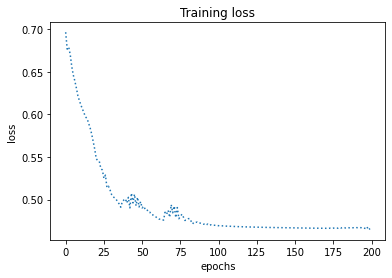

In [8]:
plt.plot(losses, linestyle = 'dotted')
plt.title("Training loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

We display the train accuracy.

In [9]:
out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_labels) / len(train_labels))

Train Accuracy: 0.8378812199036918


We display the test accuracy.

In [10]:
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.8097014925373134


# 3. Layer conductance in Captum

Here, we define the <b>*Layer Conductance*</b> object from the Captum library.

In [11]:
cond = LayerConductance(net, net.sigmoid1)

Now, we will focus mainly on how the different neurons in each layer work together to reach the prediction. <br>For instance, in our first hidden layer output containing 12 units, are all the units used for prediction? Do some units learn features positively correlated with survival while others learn features negatively correlated with survival?

In [12]:
cond_vals = cond.attribute(test_input_tensor,target=1)
cond_vals = cond_vals.detach().numpy()
print(cond_vals.shape)
print(test_input_tensor.shape)

(268, 12)
torch.Size([268, 12])


We define this function to visualize the importance of neurons in a given layer.

In [13]:
def visualize_importances(neuron_names, importances, title="Average Neuron Importances", plot=True, axis_title="Neurons"):
    print(title)
    for i in range(len(neuron_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(neuron_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, neuron_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)

We can begin by visualizing the average conductance for each neuron.
<br> formula, description of type of condu

For each neuron $y$, we calculate its conductance using this formula: <br>
<br>
$Cond^y(x) = \sum_i(x_i - x'_i) \cdot \int_{\alpha = 0}^{1} \frac{\partial F(x'+\alpha(x-x'))}{\partial y} \cdot \frac{\partial y}{\partial x_i} d\alpha$

Average Neuron Importances
Age :  0.024
SibSp :  -0.103
Parch :  0.041
Fare :  0.016
female :  -0.120
male :  -0.066
embark_C :  -0.387
embark_Q :  -0.009
embark_S :  0.039
class_1 :  -0.037
class_2 :  -0.105
class_3 :  0.030


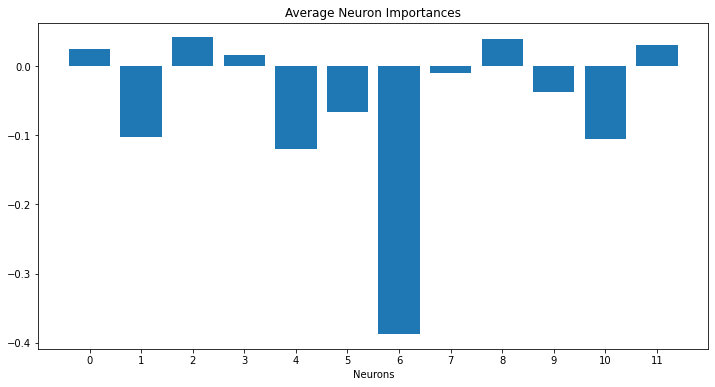

In [14]:
visualize_importances(range(12),np.mean(cond_vals, axis=0),title="Average Neuron Importances", axis_title="Neurons")

We can also look at the distribution of each neuron's attributions. Below we look at the distributions for neurons 7 and 9, and we can confirm that their attribution distributions are very close to 0, suggesting they are not learning substantial features.

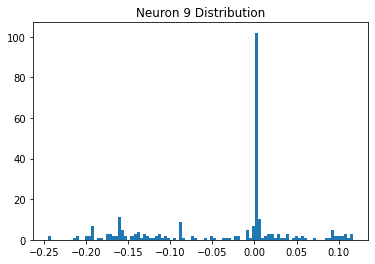

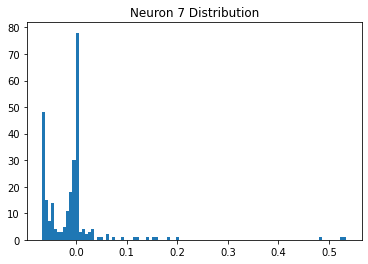

In [15]:
plt.hist(cond_vals[:,9], 100);
plt.title("Neuron 9 Distribution")
plt.figure()
plt.hist(cond_vals[:,7], 100);
plt.title("Neuron 7 Distribution");

Now, we extract the neuron attribution with regards to the input features. <br>
We focus on the cumulated gradients along a specific feature dimension in the input space. <br>

We calculate the attribution of a neuron $y$ with regards to each input feature $i$ using this formula:
<br>
$Cond^y_i(x) = (x_i - x'_i) \cdot \int_{\alpha = 0}^{1} \frac{\partial F(x'+\alpha(x-x'))}{\partial y} \cdot \frac{\partial y}{\partial x_i} d\alpha$


In [16]:
neuron_cond = NeuronConductance(net, net.sigmoid1)

In the two following cells, we fix the neuron and visualize its attribution along the input fatures.<br>
Here, we extract the attributions for the neuron 0.

In [17]:
neuron_cond_vals_0 = neuron_cond.attribute(test_input_tensor, neuron_selector=0, target=1)

Now, we extract the attributions for the neuron 2.

In [18]:
neuron_cond_vals_2 = neuron_cond.attribute(test_input_tensor, neuron_selector=2, target=1)

We viusalize the attributions of the features for the neuron 0.

Average Feature Importances for Neuron 0
Age :  -0.002
SibSp :  0.000
Parch :  0.000
Fare :  0.035
female :  0.000
male :  -0.005
embark_C :  -0.000
embark_Q :  0.001
embark_S :  -0.002
class_1 :  -0.000
class_2 :  0.001
class_3 :  -0.001


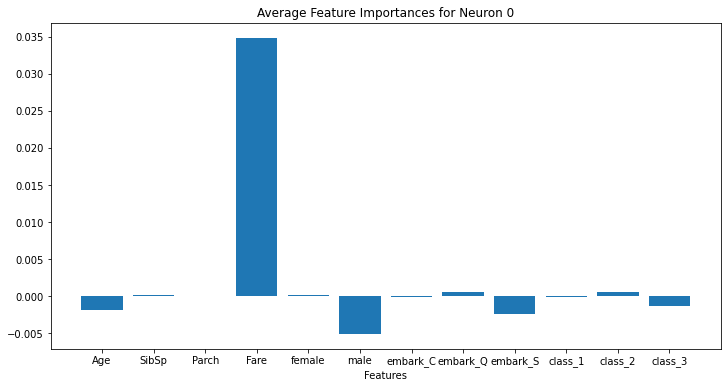

In [21]:
visualize_importances(feature_names, neuron_cond_vals_0.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 0", axis_title="Features")

We can see that, for this neuron, the most important feature is the fare.

We viusalize the attributions of the features for the neuron 10.

Average Feature Importances for Neuron 2
Age :  0.029
SibSp :  0.000
Parch :  0.000
Fare :  0.014
female :  -0.000
male :  0.002
embark_C :  0.000
embark_Q :  0.000
embark_S :  0.001
class_1 :  0.000
class_2 :  0.000
class_3 :  0.001


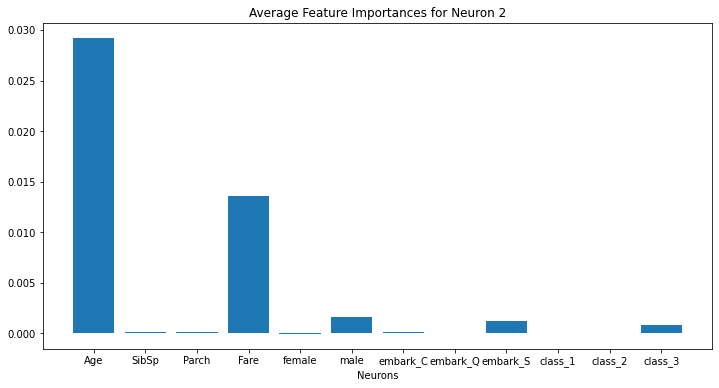

In [20]:
visualize_importances(feature_names, neuron_cond_vals_2.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 2")

This plot indicates that neuron 2 primarily relies on the age feature, substantially different from the focus of neuron 0.

Thank you!